The code in this notebook is based on: https://medium.com/@parktwin2/building-a-convolutional-neural-network-cnn-with-pytorch-bdd3c5fe47cb

In [1]:
!pip install torch torchvision

In [2]:
# Import PyTorch
import torch
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn

# Data Preparation and Loading

Use the CIFAR-10 dataset: https://en.wikipedia.org/wiki/CIFAR-10

In [3]:
# Download and load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 72181033.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Creating the CNN Architecture

The CNN architecture is defined with two convolutional layers, max pooling layers, and fully connected layers. The forward method specifies how data flows through the network. This architecture is suitable for image classification tasks and can be modified to suit your specific project requirements.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer 1 with 3 input channels (for RGB images), 6 output channels, and 5x5 kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling layer with a 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Convolutional layer 2 with 6 input channels (from the previous layer), 16 output channels, and 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the CNN

The CNN model is initialised, the loss function and optimizer are set up, and data loaders for training and validation data are created. The training loop iterates through the dataset for a specified number of epochs, performing forward and backward passes to update the model’s parameters.

In [5]:
dataset  = trainset

# Initialize your CNN model
cnn = Net()
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent optimizer
# Split your data into training and validation sets
train_size = int(0.8 * len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()  # Zero the parameter gradients to avoid accumulation
        outputs = cnn(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters
print('Finished Training')

Finished Training


# Evaluating the Model

Set the model to evaluation mode, use it to make predictions on the validation dataset, and calculate the accuracy of the model.

In [6]:
correct = 0
total = 0
# Set the model to evaluation mode
cnn.eval()
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on the validation set: {100 * correct / total:.2f}%')

Accuracy on the validation set: 62.32%


# Fine Tuning and a Pretrained Model

Fine-tuning and transfer learning are powerful techniques that allow you to leverage pre-trained models to boost the performance of your Convolutional Neural Network (CNN) while saving both time and computational resources.

Fine-tuning involves taking a pre-trained model (usually on a large dataset, like ImageNet) and adapting it to a new task with a smaller dataset. PyTorch provides access to a variety of pre-trained models through the torchvision.models module.

Here’s an example of how to fine-tune a pre-trained ResNet-18 model for a custom classification task.

The pre-trained resnet-18 models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

CIFAR-10 images are 32x32 so are unsuitable for use with resnet.

An image dataset of dandelions and daisies is downloaded from: https://www.kaggle.com/datasets/alsaniipe/flowers-dataset/code

The folders in this archive are copied to a 'Flowers' folder on google drive. The result will be three folders, 'test', 'train' and 'valid' containing the classified images.

Next, the google drive is mounted to that the notebook code can access the dataset images.

In [7]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import listdir

# Test the drive mount and existence of required directory
listdir("/content/drive/MyDrive/Flowers")

Now setup paths to the relevant folders containing the classified images and ensure that the images can be successfully accessed.

In [ ]:
# Set up paths to the dataset image directories
train_dir = "/content/drive/MyDrive/Flowers/train"
test_dir = "/content/drive/MyDrive/Flowers/test"
train_classa_dir = f"{train_dir}/daisy"
train_classb_dir = f"{train_dir}/dandelion"
test_classa_dir = f"{test_dir}/daisy"
test_classb_dir = f"{test_dir}/dandelion"

This is a daisy


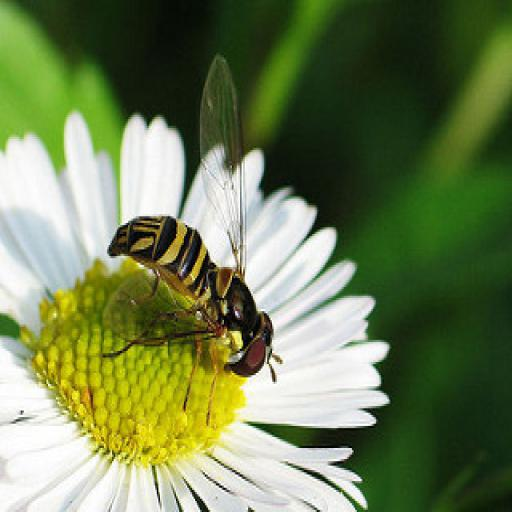

In [ ]:
import torchvision.transforms as T

# Display image for reference
white_torch = torchvision.io.read_image(f"{train_classa_dir}/5547758_eea9edfd54_n_jpg.rf.26e98f33cecb0f61bb9d02d2a22a96b5.jpg")
print("This is a daisy")
T.ToPILImage()(white_torch)

Now create the required dataset objects by suitably transforming the images into tensors.

In [ ]:
# Create transform function
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Apply for training and test data
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=False, num_workers=0)

In [ ]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 1284
Test dataset size: 182
Class names: ['daisy', 'dandelion']


Sanity check to ensure that images are properly encoded.

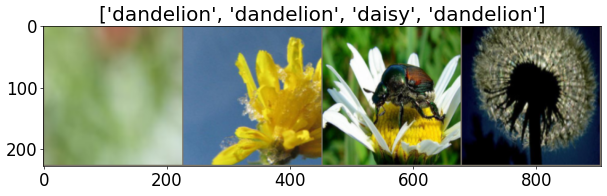

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()
# load a batch of train image
iterator = iter(train_dataloader)
# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Find out if a GPU is available
use_cuda = torch.cuda.is_available()

In [ ]:
# Load a pre-trained ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)

# Modify the final classification layer for the number of classes in your dataset
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
import time

#### Train model
train_loss=[]
train_accuary=[]
test_loss=[]
test_accuary=[]

num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        # Append result
        test_loss.append(epoch_loss)
        test_accuary.append(epoch_acc)
        # Print progress
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))


Epoch 0 running
[Train #1] Loss: 0.0145 Acc: 92.6791% Time: 14.6406s
[Test #1] Loss: 0.0124 Acc: 93.4066% Time: 15.8853s
Epoch 1 running
[Train #2] Loss: 0.0135 Acc: 93.9252% Time: 30.5847s
[Test #2] Loss: 0.0123 Acc: 94.5055% Time: 31.9141s
Epoch 2 running
[Train #3] Loss: 0.0150 Acc: 93.3801% Time: 46.6286s
[Test #3] Loss: 0.0110 Acc: 93.9560% Time: 47.8699s
Epoch 3 running
[Train #4] Loss: 0.0133 Acc: 93.3801% Time: 62.5183s
[Test #4] Loss: 0.0127 Acc: 93.4066% Time: 63.7424s
Epoch 4 running
[Train #5] Loss: 0.0134 Acc: 93.4579% Time: 79.8742s
[Test #5] Loss: 0.0118 Acc: 94.5055% Time: 81.4992s
Epoch 5 running
[Train #6] Loss: 0.0146 Acc: 93.3022% Time: 95.9745s
[Test #6] Loss: 0.0122 Acc: 93.4066% Time: 97.6461s
Epoch 6 running
[Train #7] Loss: 0.0143 Acc: 93.2243% Time: 112.1313s
[Test #7] Loss: 0.0114 Acc: 94.5055% Time: 113.7667s
Epoch 7 running
[Train #8] Loss: 0.0137 Acc: 94.0031% Time: 128.1433s
[Test #8] Loss: 0.0124 Acc: 93.4066% Time: 129.6313s
Epoch 8 running
[Train #9] L

In [ ]:
save_path = '/content/drive/MyDrive/Flowers/flowers_resnet_18_final.pth'
torch.save(model.state_dict(), save_path)

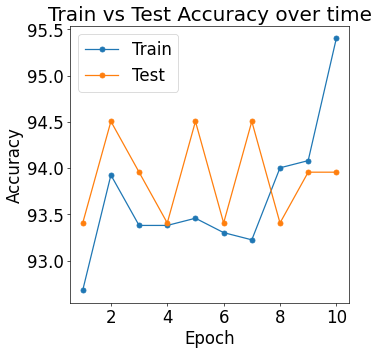

In [ ]:
# Plot
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,num_epochs+1), train_accuary,'-o')
plt.plot(np.arange(1,num_epochs+1), test_accuary,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy over time')
plt.show()